In [2]:
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from theano import tensor as T
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [354]:
# Load training data
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

cats = df[df['category'] == '0']
cats = cats.head(750)

dogs = df[df['category'] == '1']
dogs = dogs.head(750)

df = cats.append(dogs)

print(df)

           filename category
1      cat.5077.jpg        0
3      cat.2718.jpg        0
4     cat.10151.jpg        0
5      cat.3406.jpg        0
7      cat.4369.jpg        0
8      cat.7660.jpg        0
10     cat.8553.jpg        0
11     cat.9895.jpg        0
12     cat.1211.jpg        0
16     cat.6218.jpg        0
19     cat.1577.jpg        0
20    cat.12020.jpg        0
22     cat.7106.jpg        0
23     cat.8235.jpg        0
24      cat.952.jpg        0
27     cat.3360.jpg        0
28    cat.11529.jpg        0
29    cat.10637.jpg        0
33     cat.5711.jpg        0
34      cat.946.jpg        0
35     cat.3374.jpg        0
38    cat.10623.jpg        0
40     cat.5705.jpg        0
45     cat.1563.jpg        0
47    cat.12034.jpg        0
49     cat.7112.jpg        0
51     cat.8221.jpg        0
54     cat.7674.jpg        0
55     cat.8547.jpg        0
56     cat.9881.jpg        0
...             ...      ...
1425   dog.8986.jpg        1
1427   dog.9440.jpg        1
1429   dog.677

In [355]:
# Split into train and validation set
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [356]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16
input_size=(227, 227, 3)
nb_classes=2
using_mean=False

In [357]:
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

In [358]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col="filename",
    y_col="category",
    shuffle=True,
    target_size=input_size[:2],
    class_mode='categorical',
    batch_size=batch_size
)

Found 1200 images belonging to 2 classes.


In [359]:
validate_generator = train_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col="filename",
    y_col="category",
    shuffle=True,
    target_size=input_size[:2],
    class_mode='categorical',
    batch_size=batch_size
)

Found 300 images belonging to 2 classes.


In [360]:
def mean_subtract(img):   
    img = T.set_subtensor(img[:,0,:,:],img[:,0,:,:] - 123.68)
    img = T.set_subtensor(img[:,1,:,:],img[:,1,:,:] - 116.779)
    img = T.set_subtensor(img[:,2,:,:],img[:,2,:,:] - 103.939)

    return img / 255.0

def build_alexnet(input_size, nb_classes, using_mean):
    alexnet = Sequential()
    
    # Layer 1
    alexnet.add(Conv2D(input_shape=input_size, filters=96,
                   kernel_size=(11, 11), strides=(4, 4), padding='valid'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Layer 2
    alexnet.add(ZeroPadding2D((2, 2)))
    alexnet.add(Conv2D(filters=192, kernel_size=(5, 5), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    
    # Layer 4
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    
    # Layer 5 Conv
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Layer 6 FC
    alexnet.add(Flatten())
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 7 FC
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 8 Softmax
    alexnet.add(Dense(nb_classes))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('softmax'))
    
    return alexnet
        

In [361]:
model = build_alexnet(input_size, nb_classes, using_mean)

In [362]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_17 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_49 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_25 (ZeroPaddi (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 31, 31, 192)       460992    
_________________________________________________________________
batch_normalization_18 (Batc (None, 31, 31, 192)       768       
__________

In [363]:
from keras.optimizers import SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [364]:
history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validate_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    verbose=1
)

Epoch 1/10
75/75 [==============================] - 192s 3s/step - loss: 0.2734 - acc: 0.4992 - val_loss: 0.2873 - val_acc: 0.5208
Epoch 2/10
75/75 [==============================] - 163s 2s/step - loss: 0.2516 - acc: 0.5192 - val_loss: 0.2573 - val_acc: 0.5669
Epoch 3/10
75/75 [==============================] - 163s 2s/step - loss: 0.2454 - acc: 0.5567 - val_loss: 0.2591 - val_acc: 0.5176
Epoch 4/10
75/75 [==============================] - 162s 2s/step - loss: 0.2456 - acc: 0.5767 - val_loss: 0.2533 - val_acc: 0.5387
Epoch 5/10
75/75 [==============================] - 163s 2s/step - loss: 0.2347 - acc: 0.5958 - val_loss: 0.2622 - val_acc: 0.5739
Epoch 6/10
75/75 [==============================] - 162s 2s/step - loss: 0.2211 - acc: 0.6458 - val_loss: 0.2514 - val_acc: 0.5951
Epoch 7/10
75/75 [==============================] - 163s 2s/step - loss: 0.2205 - acc: 0.6483 - val_loss: 0.2459 - val_acc: 0.6197
Epoch 8/10
75/75 [==============================] - 163s 2s/step - loss: 0.2070 - a

In [365]:
# save model
model.save_weights("model.h1200")

In [144]:
from scipy.misc import imread, imresize, imsave
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode="rgb", out=None):
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode=="bgr":
            img[:,:,[0,1,2]] = img[:,:,[2,1,0]]
#         img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[(img_size[0]-crop_size[0])//2:(img_size[0]+crop_size[0])//2
                      ,(img_size[1]-crop_size[1])//2:(img_size[1]+crop_size[1])//2,:]
        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

/Users/cuong/PycharmProjects/AlexNet-A-Practical-Implementation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/cuong/PycharmProjects/AlexNet-A-Practical-Implementation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


[[0.9320156  0.06798445]]
Predict:  cat


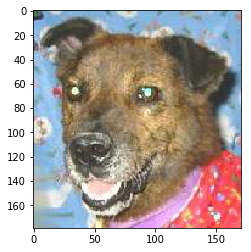

In [392]:
sample = random.choice(filenames)
im = preprocess_image_batch(["train/"+sample],img_size=(256,256), crop_size=(227,227), color_mode="rgb")
image = load_img("train/"+sample)
plt.imshow(image)
y_prob = model.predict(im)
print(y_prob)
y_class = y_prob.argmax(axis=-1)
print("Predict: ", ("cat" if y_class == 0 else "dog"))